<a href="https://colab.research.google.com/github/segnig/Zindi-Competitions/blob/main/outsmarting-outbreaks-challenge/OutsmartingOutbreaks_StarterNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [4]:
FILE_PATH = "/content/drive/MyDrive/Data Science/outsmarting-outbreaks-challenge20241207-28044-iehqcg/"

In [5]:
# Load datasets
train = pd.read_csv(FILE_PATH + "Train.csv")
test = pd.read_csv(FILE_PATH + "Test.csv")
toilets = pd.read_csv(FILE_PATH + "toilets.csv")
waste_management = pd.read_csv(FILE_PATH + "waste_management.csv")
water_sources = pd.read_csv(FILE_PATH + "water_sources.csv")

In [7]:
train.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267


In [8]:
test.head()

,Location,Disease,Month,Category_Health_Facility_UUID,Year,Transformed_Latitude,Transformed_Longitude,ID
0,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,1,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_1_2023...
1,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,2,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_2_2023...
2,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,3,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_3_2023...
3,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,4,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_4_2023...
4,ID_00cd8292-dd85-4fa3-8148-9592e88a1651,Diarrhea,5,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,2023,-8.52657,68.23638,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_5_2023...


In [10]:
# shape of train dataset and test dataset
print("shape of train datase =", train.shape)
print("shape of test datase =", test.shape)

shape of train datase = (23848, 9)
shape of test datase = (4872, 8)


In [21]:
VariableDefinitions = pd.read_csv(FILE_PATH + "VariableDefinitions.txt", delimiter=" - ", header=None, names=["Variable", "Definition"]).set_index("Variable")
VariableDefinitions.loc["10v", :]

,10v
Definition,Meridional wind component at 10 meters above the surface (north-south direction)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23848 entries, 0 to 23847
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             23848 non-null  object 
 1   Total                          23847 non-null  float64
 2   Location                       23848 non-null  object 
 3   Category_Health_Facility_UUID  23848 non-null  object 
 4   Disease                        23848 non-null  object 
 5   Month                          23848 non-null  int64  
 6   Year                           23848 non-null  int64  
 7   Transformed_Latitude           23848 non-null  float64
 8   Transformed_Longitude          23848 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.6+ MB


In [23]:
# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [26]:
# Look at informtion of train and test dataset
hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28720 entries, 0 to 4871
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             28720 non-null  object 
 1   Total                          23847 non-null  float64
 2   Location                       28720 non-null  object 
 3   Category_Health_Facility_UUID  28720 non-null  object 
 4   Disease                        28720 non-null  object 
 5   Month                          28720 non-null  int64  
 6   Year                           28720 non-null  int64  
 7   Transformed_Latitude           28720 non-null  float64
 8   Transformed_Longitude          28720 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.2+ MB


In [27]:
# Look at informtion of train and test dataset
for df in [train, test]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23848 entries, 0 to 23847
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             23848 non-null  object 
 1   Total                          23847 non-null  float64
 2   Location                       23848 non-null  object 
 3   Category_Health_Facility_UUID  23848 non-null  object 
 4   Disease                        23848 non-null  object 
 5   Month                          23848 non-null  int64  
 6   Year                           23848 non-null  int64  
 7   Transformed_Latitude           23848 non-null  float64
 8   Transformed_Longitude          23848 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  

In [28]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

In [29]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")


In [30]:
# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

In [31]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [32]:
# Visualize locations for a specific year and month
# Note the months/year should in the given timeframe [2019, 2023]
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(12, 8))
    subsets = [
        (hospital_data.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_sources.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_management.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.6, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

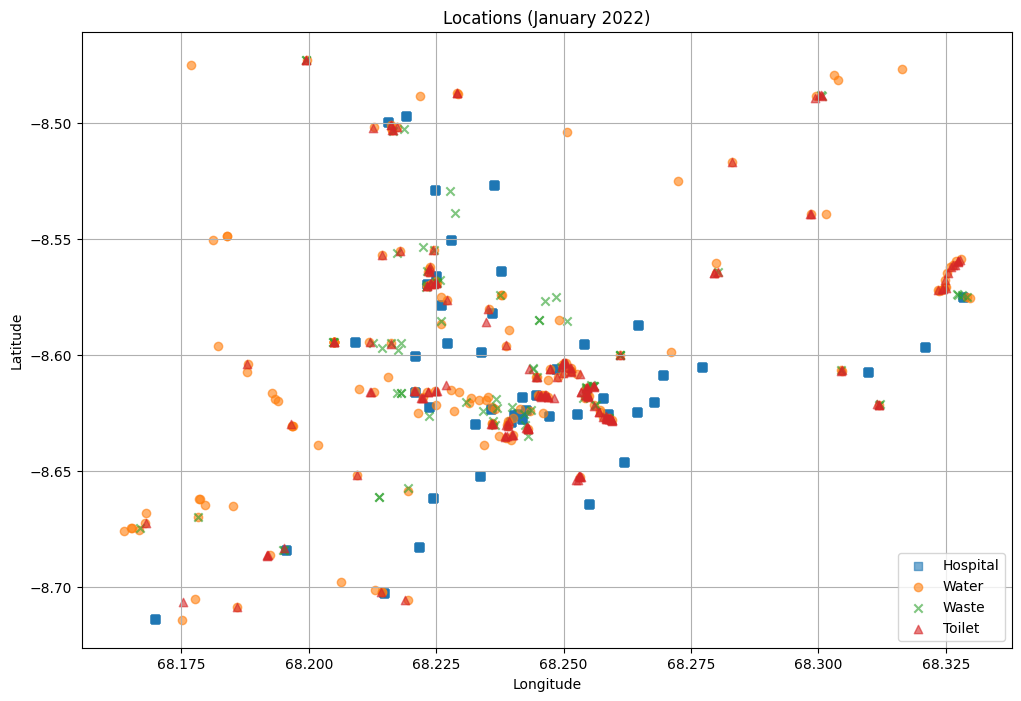

In [ ]:
plot_locations()

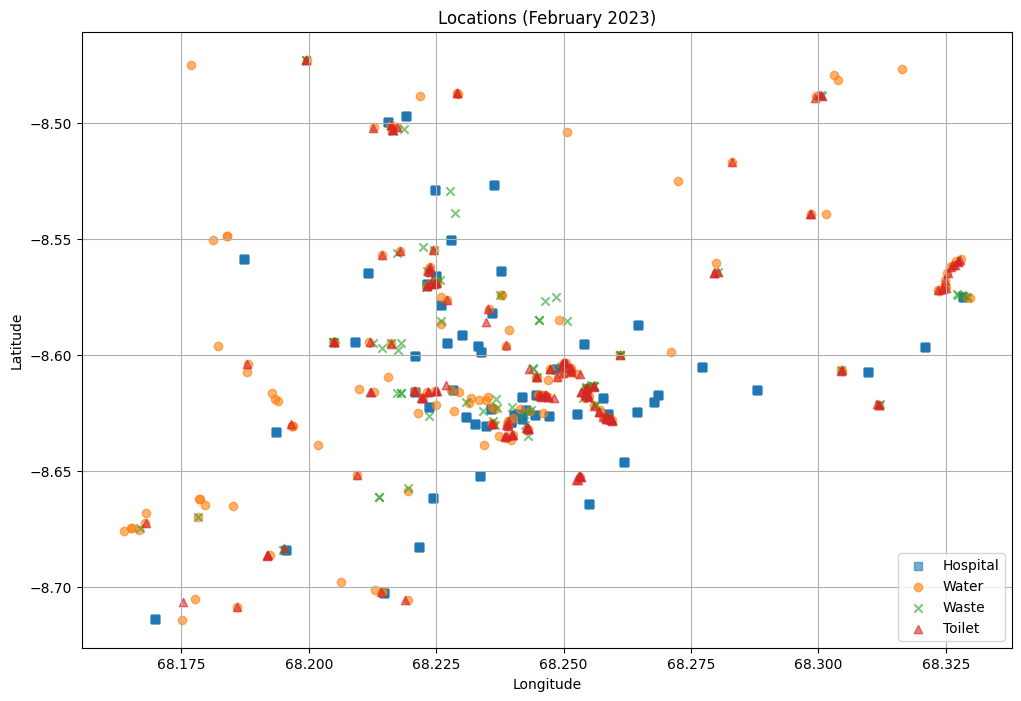

In [ ]:
plot_locations(year=2023, month=2, month_name='February')

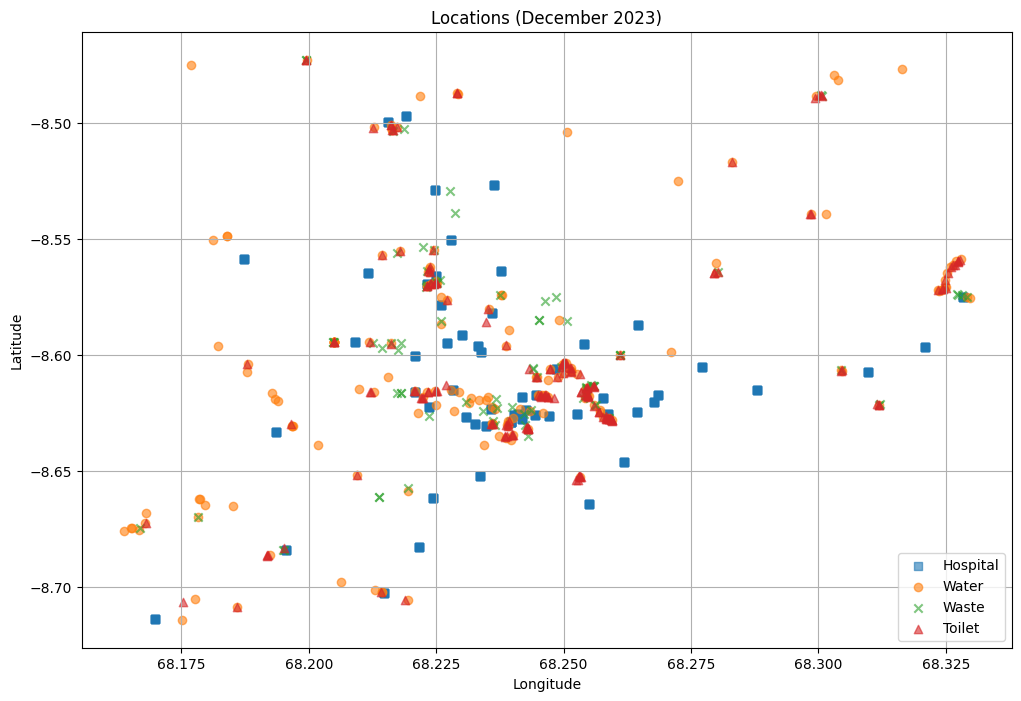

In [ ]:
plot_locations(year=2023, month=12, month_name='December')

In [ ]:
plot_locations(year=2000, month=1, month_name='January')

Invalid year. Please choose a year between 2019 and 2023.


In [33]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest


In [34]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [ ]:
toilets.head()

,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,...,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon,Month_Year_lat_lon,toilet_Month_Year_lat_lon
0,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,...,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536,1_2019_-8.61768_68.24536
1,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,...,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536,2_2019_-8.61768_68.24536
2,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,...,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536,3_2019_-8.61768_68.24536
3,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,...,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536,4_2019_-8.61768_68.24536
4,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,...,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536,5_2019_-8.61768_68.24536


In [35]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [36]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

In [38]:
merged_data.shape

(29332, 135)

In [39]:
merged_data.head(2)

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,toilet_lai_hv,toilet_lai_lv,toilet_pev,toilet_ro,toilet_src,toilet_skt,toilet_es,toilet_stl1,toilet_stl2,toilet_stl3,toilet_stl4,toilet_ssro,toilet_slhf,toilet_ssr,toilet_str,toilet_sp,toilet_sro,toilet_sshf,toilet_ssrd,toilet_strd,toilet_e,toilet_tp,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon_x,Month_Year_lat_lon_x,waste_Month_Year_lat_lon,waste_10u,waste_10v,waste_2d,waste_2t,waste_evabs,waste_evaow,waste_evatc,waste_evavt,waste_albedo,waste_lshf,waste_lai_hv,waste_lai_lv,waste_pev,waste_ro,waste_src,waste_skt,waste_es,waste_stl1,waste_stl2,waste_stl3,waste_stl4,waste_ssro,waste_slhf,waste_ssr,waste_str,waste_sp,waste_sro,waste_sshf,waste_ssrd,waste_strd,waste_e,waste_tp,waste_swvl1,waste_swvl2,waste_swvl3,waste_swvl4,waste_Transformed_Latitude,waste_Transformed_Longitude,waste_Month_Year,lat_lon_y,Month_Year_lat_lon_y,water_Month_Year_lat_lon,water_10u,water_10v,water_2d,water_2t,water_evabs,water_evaow,water_evatc,water_evavt,water_albedo,water_lshf,water_lai_hv,water_lai_lv,water_pev,water_ro,water_src,water_skt,water_es,water_stl1,water_stl2,water_stl3,water_stl4,water_ssro,water_slhf,water_ssr,water_str,water_sp,water_sro,water_sshf,water_ssrd,water_strd,water_e,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Dysentery,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,-0.268989,0.434248,293.688,295.826,-0.001586,-0.000559,-0.001427,-2.514570e-08,0.180957,0.650009,4.77283,1.94531,-0.007145,0.006419,0.000292,296.303,0.0,297.01,297.133,297.461,297.89,0.003894,-8932350,12919600,-2207800,93553.6,0.002524,-1906560,15773400,35506000,-0.003572,0.010136,0.410492,0.412476,0.418381,0.421661,-8.62979,68.23582,4_2020,-8.62979_68.23582,4_2020_-8.62979_68.23582,5_2021_-8.62861_68.23612,-0.231009,0.88069,290.091,294.521,-0.00243,-0.000788,-0.00035,-2.747400e-08,0.182368,0.649994,4.79968,1.97473,-0.009929,0.0002,0.000062,294.795,0.0,295.515,295.729,296.361,297.447,0.00018,-8922480,14507500,-3822210,93703.6,0.00002,-1948450,17743800,33066900,-0.003568,0.000982,0.29657,0.321991,0.363693,0.340363,-8.62861,68.23612,5_2021,-8.62861_68.23612,5_2021_-8.62861_68.23612,12_2023_-8.62966_68.23589,-1.02042,-0.517984,293.889,297.52,-0.001427,-0.000598,-0.000564,-1.722950e-08,0.172082,0.650001,4.55408,1.7373,-0.007022,0.000287,0.000147,298.302,0.0,298.864,298.698,298.245,297.741,0.000004,-6474240,11130500,-1484820,93346.5,0.000283,-2630750,13444000,18697700,-0.002589,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_2022_Typhoid,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,-0.268989,0.434248,293.688,295.826,-0.001586,-0.000559,-0.001427,-2.514570e-08,0.180957,0.650009,4.77283,1.94531,-0.007145,0.006419,0.000292,296.303,0.0,297.01,297.133,297.461,297.89,0.003894,-8932350,12919600,-2207800,93553.6,0.002524,-1906560,15773400,35506000,-0.003572,0.010136,0.410492,0.412476,0.418381,0.421661,-8.62979,68.23582,4_2020,-8.62979_68.23582,4_2020_-8.62979_68.23582,5_2021_-8.62861_68.23612,-0.231009,0.88069,290.091,294.521,-0.00243,-0.000788,-0.00035,-2.747400e-08,0.182368,0.649994,4.79968,1.97473,-0.009929,0.0002,0.000062,294.795,0.0,295.515,295.729,296.361,297.447,0.00018,-8922480,14507500,-3822210,93703.6,0.00002,-1948450,17743800,33066900,-0.003568,0.000982,0.29657,0.321991

## Start modeling

In [40]:
# Split merged data into train and test sets
train_df = merged_data[merged_data['Year'] < 2023]
test_df = merged_data[merged_data['Year'] == 2023]

In [41]:
# Specify the target column
target_column = 'Total'

# Feature and target split
X = train_df.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns
y = train_df[target_column]

In [42]:
# Handle categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [44]:
X.shape

(24376, 132)

In [45]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Initialize and train the regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [48]:
# Make predictions
y_pred = model.predict(X_test)

In [49]:
y_pred

array([ 3.14613095,  0.        ,  0.17210714, ...,  0.04      ,
        2.43197619, 32.73207143])

In [50]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 10.97772298017639


#### Make predictions on test

In [51]:
# Prepare test data
X_test_final = test_df.drop(columns=['Total', 'ID', 'Location'], errors='ignore')

In [52]:
# Handle categorical features in test data
for col in categorical_cols:
    if col in X_test_final.columns:
        le = LabelEncoder()
        X_test_final[col] = le.fit_transform(X_test_final[col])

In [53]:
# Align test dataset with training features
for col in X.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = 0  # Add missing feature with default value (e.g., zero)


In [54]:
# Ensure columns are in the same order as training
X_test_final = X_test_final[X.columns]

In [55]:
# Make predictions on test data
predictions = model.predict(X_test_final)

In [56]:
# Create the final DataFrame with ID and predictions
sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions

In [57]:
# View the first few records in sub
sub.head()

,ID,Predicted_Total
24376,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_1_2023_Diarrhea,22.698667
24377,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_2_2023_Diarrhea,21.372226
24378,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_3_2023_Diarrhea,25.992492
24379,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_4_2023_Diarrhea,22.073952
24380,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_5_2023_Diarrhea,13.077524


In [58]:
# Save the final DataFrame to a CSV
sub.to_csv(FILE_PATH + 'Benchmark.csv', index=False)